In [5]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score



In [6]:
### DEFINE SOME PARAMETERS ###

all_path = "G:\\06  Projekte\\72 KI\\01 Studenten\\2023_06_Couture\\ball_tracking\\object"
SHAPE = (224,224,3)
batch_size = 32

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
            all_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['ball_train']
)

test_generator = test_datagen.flow_from_directory(
            all_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['ball','other']
)




Found 111 images belonging to 1 classes.


Found 450 images belonging to 2 classes.


In [7]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(train=True):
    print("0")
    
    set_seed(33)
    
    pre_process = Lambda(preprocess_input)
    vgg = VGG16(weights = 'imagenet', include_top = True, input_shape = SHAPE)
    vgg = Model(vgg.input, vgg.layers[-3].output)
    vgg.trainable = False
    
    inp = Input(SHAPE)
    vgg_16_process = pre_process(GaussianNoise(0.5)(inp))
    vgg_out = vgg(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.1)(noise)
    print(noise.shape)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out
        
    print("1")

        
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(Adam(lr=1e-4), loss='binary_crossentropy')
    
    return model


### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        print("\nshape:",x.shape,y.shape)
        y = tf.keras.utils.to_categorical(y)
        print("\ny:",y.shape)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        
        yield x,y
        
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [8]:


es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)
print(train_generator.samples,train_generator.batch_size)

model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=15)




111 32
0


(None, 4096)
1

shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
Epoch 1/15

shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
1/3 [=======>......................] - ETA: 6s - loss: 1.2880
shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
2/3 [================>.............] - ETA: 2s - loss: 0.8633
shape: (15, 224, 224, 3) (15, 1)

y: (15, 2)
3/3 [========================>.....] - ETA: 0s - loss: 0.7145
shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
3/3 [==============================] - 7s 2s/step - loss: 0.6648 
Epoch 2/15

shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
1/3 [=======>......................] - ETA: 4s - loss: 0.2558
shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
2/3 [================>.............] - ETA: 2s - loss: 0.2135
shape: (15, 224, 224, 3) (15, 1)

y: (15, 2)
3/3 [========================>.....] - ETA: 0s - loss: 0.1832
shape: (32, 224, 224, 3) (32, 1)

y: (32, 2)
3/3 [==============================] - 6s 2s/step - loss: 0.1694 
Epoch 3/15

shape: (32, 224, 224, 3) (32, 1)

y: (3

0


(None, 4096)
1
15/15 [==============================] - 31s 2s/step
ACCURACY: 0.8466666666666667


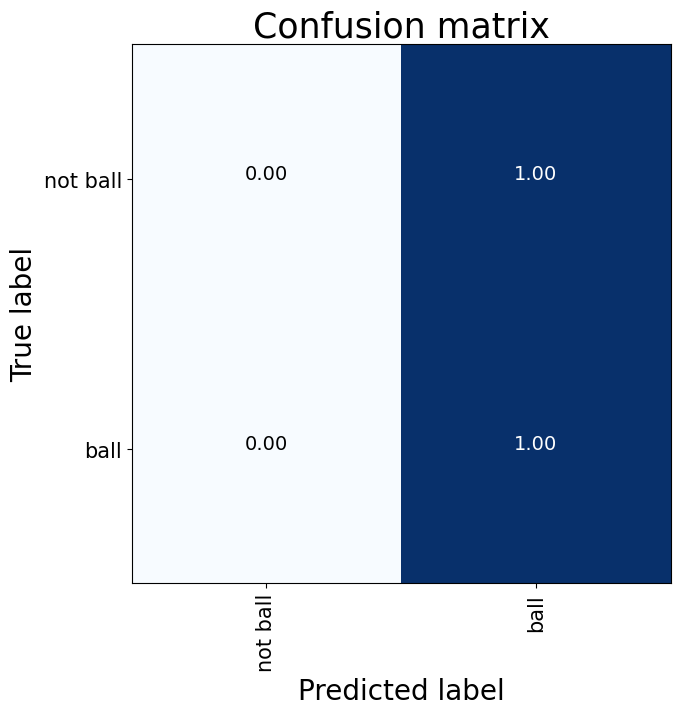

In [9]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
ineference_model.set_weights(model.get_weights())


### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)


### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))



### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['not ball','ball'])
plt.show()
